In [1]:
import scikit_posthocs as sp
from types import SimpleNamespace
from pathlib import Path
import subprocess
import seaborn as sns
import pandas as pd
import os
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# vars
path_workdir = Path("/home/b05b01002/HDD/project_nanoprep_re")
path_input = path_workdir / "outputs/SQANTI"
path_output = Path("./output")
os.makedirs(path_output, exist_ok=True)

names = [
    "egr-109-bio1",
    "egr-109-bio2",
    "lch-109-bio1",
    "lch-109-bio2",
    "ptr-109-bio1",
    "ptr-109-bio2",
    "ptr-111-bio1",
    "ont-10x-human",
    "ont-visium-mouse",
    "mouse-retina-subset1",
    "mouse-retina-subset2"
]
accuracies = [
    "sup",
    "hac",
    "fast"
]
betas = [f"beta{i}" for i in ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0", "1.5", "2.0"]]
backends = ["phmm", "edlib"]
softwares = ["nanoprep", "pychopper"]

Get all isoform classification results

In [2]:
result = subprocess.run(["find", str(path_input), "-name", "isoforms_classification.txt"], capture_output=True, text=True, check=True)
isoform_cls_txt = result.stdout.strip().split("\n")
isoform_cls_txt[:5]

['/home/b05b01002/HDD/project_nanoprep_re/outputs/SQANTI/nanoprep/beta0.3/ptr-111-bio1_hac/isoforms_classification.txt',
 '/home/b05b01002/HDD/project_nanoprep_re/outputs/SQANTI/nanoprep/beta0.3/ptr-109-bio1_hac/isoforms_classification.txt',
 '/home/b05b01002/HDD/project_nanoprep_re/outputs/SQANTI/nanoprep/beta0.3/ont-visium-mouse_sup/isoforms_classification.txt',
 '/home/b05b01002/HDD/project_nanoprep_re/outputs/SQANTI/nanoprep/beta0.3/ptr-109-bio2_hac/isoforms_classification.txt',
 '/home/b05b01002/HDD/project_nanoprep_re/outputs/SQANTI/nanoprep/beta0.3/ptr-109-bio2_sup/isoforms_classification.txt']

In [3]:
category_counts_all = pd.DataFrame()
re_categorize = {
    "full-splice_match": "full-splice_match",
    "incomplete-splice_match": "incomplete-splice_match",
    "novel_in_catalog": "novel_in_catalog",
    "novel_not_in_catalog": "novel_not_in_catalog",
    "antisense": "others",
    "fusion": "others",
    "genic": "others",
    "genic_intron": "others",
    "intergenic": "others"
}
for fname in isoform_cls_txt:
    software, beta_or_backend, name_accuracy = fname.split("/")[-4:-1]
    name, accuracy = name_accuracy.split("_")
    df = pd.read_csv(fname, sep="\t")
    df["structural_category"] = df["structural_category"].map(re_categorize)
    category_counts = df.groupby(by=["structural_category"]).size().reset_index(name="count")
    category_counts["softwares"] = software
    category_counts["beta_or_backend"] = beta_or_backend
    category_counts["name"] = name
    category_counts["accuracy"] = accuracy
    category_counts_all = pd.concat([category_counts_all, category_counts])
    

Sort for plotting

In [4]:
category_counts_all = category_counts_all[~(category_counts_all["beta_or_backend"] == "beta0.05")]
software_order = {n: idx for idx, n in enumerate(backends + betas)}
category_counts_all["software_order"] = category_counts_all["beta_or_backend"].map(software_order)
category_counts_all = category_counts_all.sort_values(by=["software_order", "accuracy"])
category_counts_all

,structural_category,count,softwares,beta_or_backend,name,accuracy,software_order
0,full-splice_match,868,pychopper,phmm,ont-visium-mouse,fast,0
1,incomplete-splice_match,1237,pychopper,phmm,ont-visium-mouse,fast,0
2,novel_in_catalog,8,pychopper,phmm,ont-visium-mouse,fast,0
3,novel_not_in_catalog,74,pychopper,phmm,ont-visium-mouse,fast,0
4,others,156,pychopper,phmm,ont-visium-mouse,fast,0
...,...,...,...,...,...,...,...
0,full-splice_match,274,nanoprep,beta2.0,lch-109-bio1,sup,13
1,incomplete-splice_match,98,nanoprep,beta2.0,lch-109-bio1,sup,13
2,novel_in_catalog,36,nanoprep,beta2.0,lch-109-bio1,sup,13
3,novel_not_in_catalog,310,nanoprep,beta2.0,lch-109-bio1,sup,13


In [5]:
category_counts_all.loc[category_counts_all["accuracy"] == "pre-called", "accuracy"] = "sup"

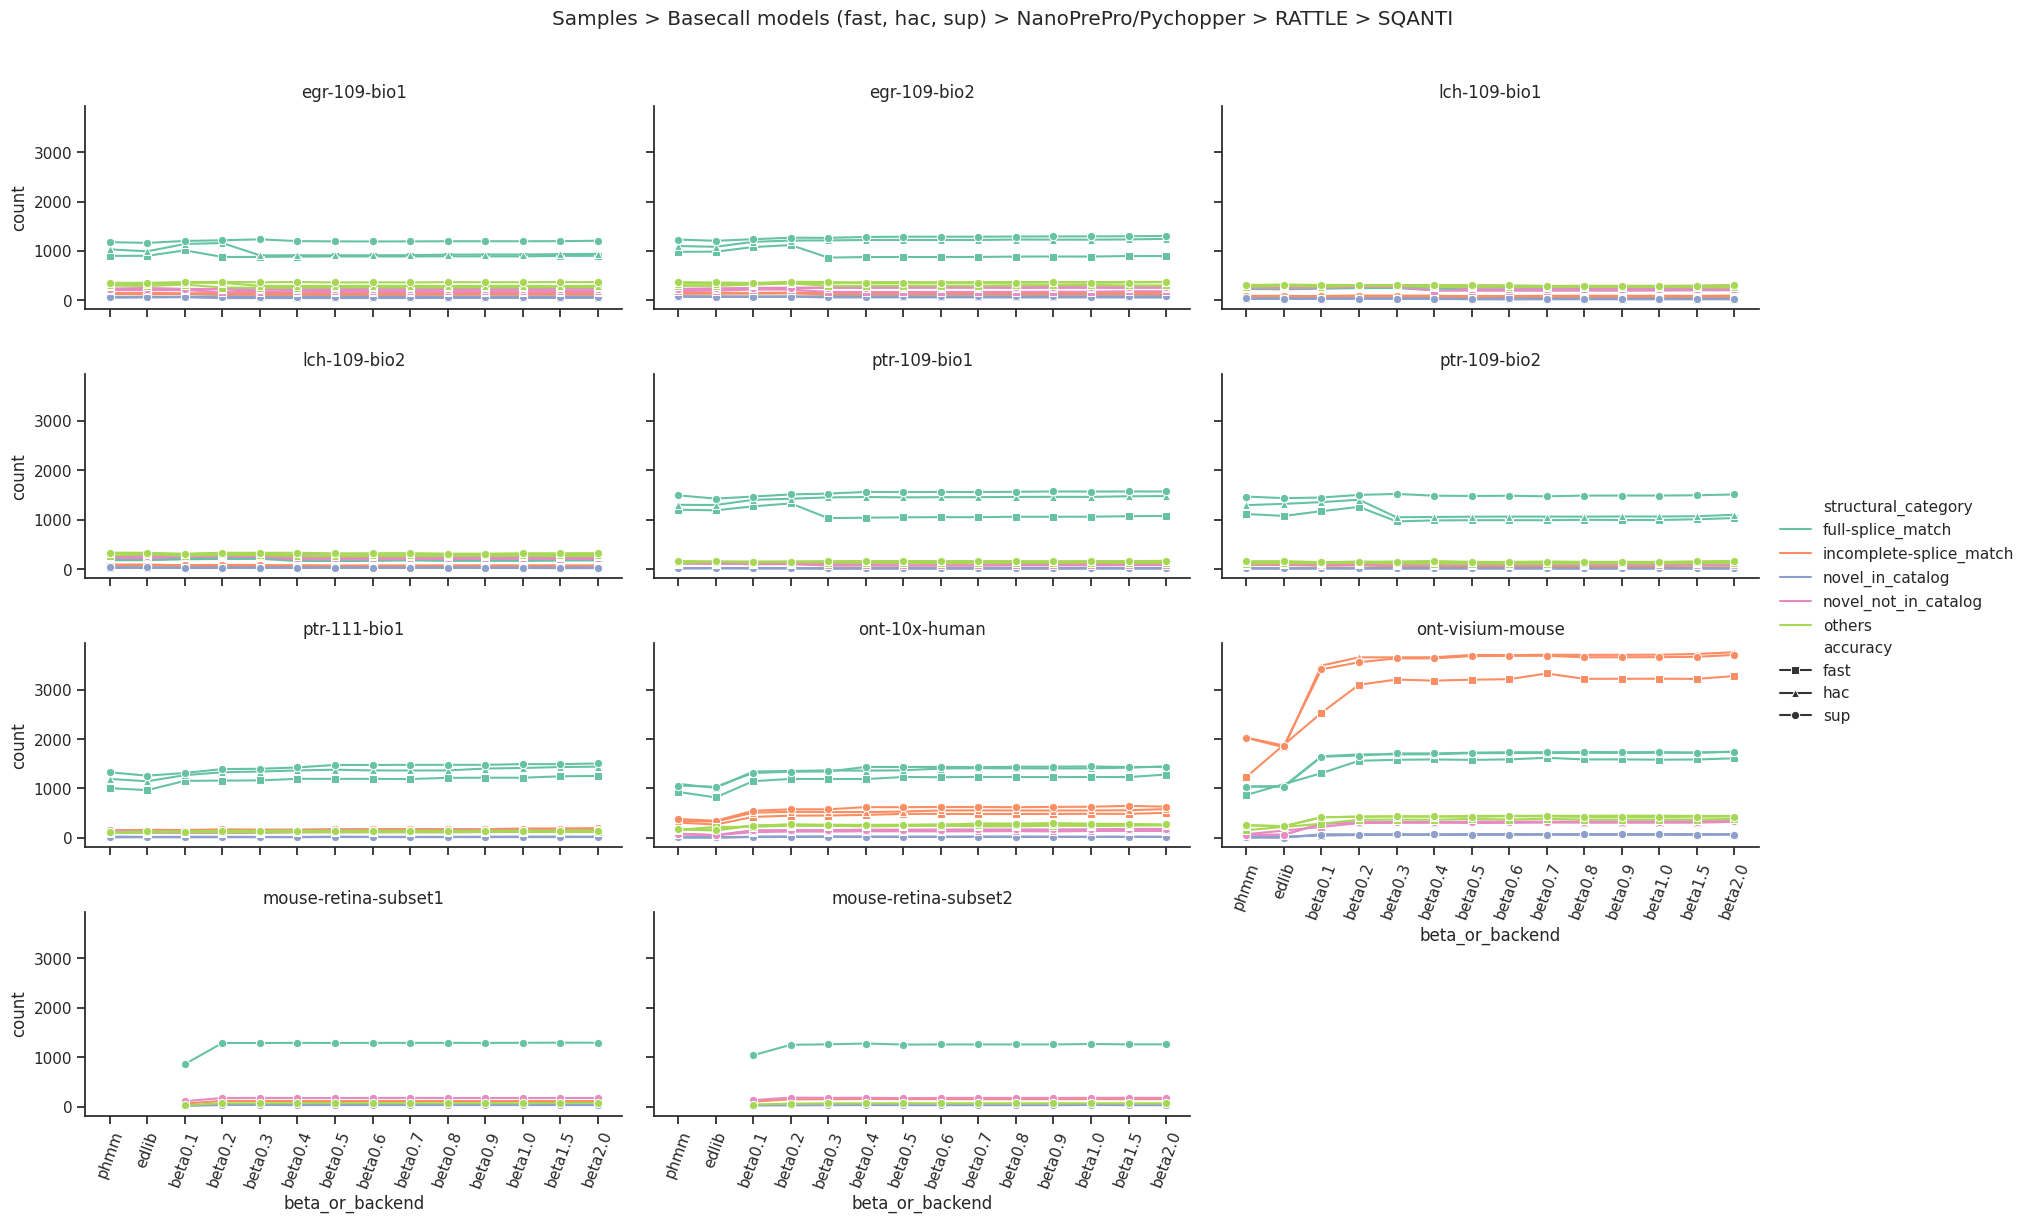

In [6]:
categories = [
    "full-splice_match",
    "incomplete-splice_match",
    "novel_in_catalog",
    "novel_not_in_catalog",
    "others"
]
set2_colors = sns.color_palette("Set2", 5).as_hex()
palette = dict(zip(categories, set2_colors))
sns.set_theme(style="ticks")
g = sns.FacetGrid(category_counts_all, col="name", col_wrap=3, aspect=2, col_order=names)
g.map_dataframe(
    sns.lineplot,
    x="beta_or_backend",
    y="count",
    hue="structural_category",
    style="accuracy",
    markers={"sup": "o", "hac": "^", "fast": "s"},
    dashes=False,
    palette=palette,
    hue_order=categories
)
g.add_legend()
g.set_titles("{col_name}")
g.fig.suptitle("Samples > Basecall models (fast, hac, sup) > NanoPrePro/Pychopper > RATTLE > SQANTI")
g.fig.subplots_adjust(top=0.9)
g.tick_params(axis="x", rotation=70)
g.savefig(path_output / "isoform_classification.svg")

In [7]:
category_counts_all[(category_counts_all["name"] == "ptr-111-bio1") & (category_counts_all["structural_category"] == "full-splice_match")]

,structural_category,count,softwares,beta_or_backend,name,accuracy,software_order
0,full-splice_match,1006,pychopper,phmm,ptr-111-bio1,fast,0
0,full-splice_match,1193,pychopper,phmm,ptr-111-bio1,hac,0
0,full-splice_match,1328,pychopper,phmm,ptr-111-bio1,sup,0
0,full-splice_match,966,pychopper,edlib,ptr-111-bio1,fast,1
0,full-splice_match,1146,pychopper,edlib,ptr-111-bio1,hac,1
0,full-splice_match,1259,pychopper,edlib,ptr-111-bio1,sup,1
0,full-splice_match,1154,nanoprep,beta0.1,ptr-111-bio1,fast,2
0,full-splice_match,1269,nanoprep,beta0.1,ptr-111-bio1,hac,2
0,full-splice_match,1314,nanoprep,beta0.1,ptr-111-bio1,sup,2
0,full-splice_match,1160,nanoprep,beta0.2,ptr-111-bio1,fast,3


Wilcoxon Pychopper vs. NanoPrePro

/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: User

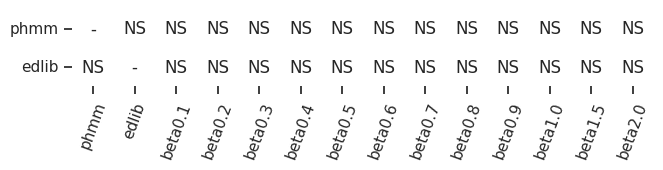

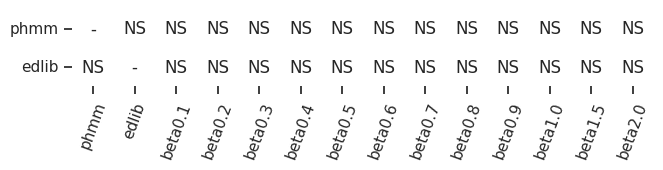

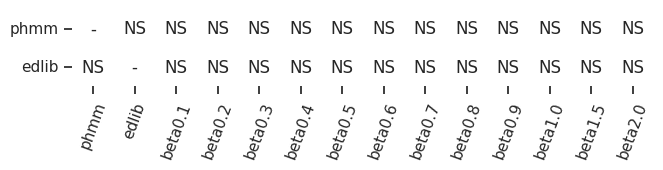

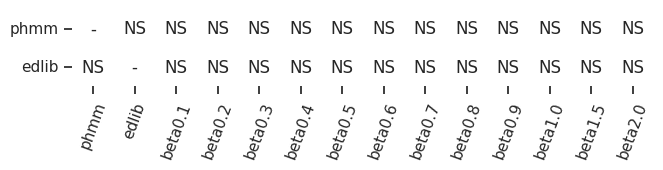

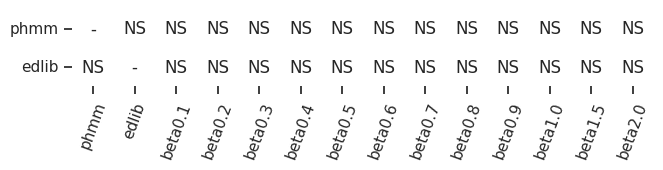

In [8]:
not_pcs114 = ~category_counts_all["name"].isin(["mouse-retina-subset1", "mouse-retina-subset2"])
not_visium_mouse_fast = ~(category_counts_all["name"].isin(["ont-visium-mouse"]) & category_counts_all["accuracy"].isin(["fast"]))
# not_phmm = ~category_counts_all["beta_or_backend"].isin(["phmm"])
# not_edlib = ~category_counts_all["beta_or_backend"].isin(["edlib"])

for category in categories:
    is_category = category_counts_all["structural_category"].isin([category])
    res_phmm = sp.posthoc_wilcoxon(
        category_counts_all[not_pcs114 & not_visium_mouse_fast & is_category],
        val_col="count",
        group_col="beta_or_backend",
        zero_method="zsplit",
        p_adjust="fdr_bh"
    )
    res_edlib = sp.posthoc_wilcoxon(
        category_counts_all[not_pcs114 & not_visium_mouse_fast & is_category],
        val_col="count",
        group_col="beta_or_backend",
        zero_method="zsplit",
        p_adjust="fdr_bh"
    )
    res = pd.concat([res_phmm.loc[["phmm"]], res_edlib.loc[["edlib"]]])
    res = res.loc[:, backends + betas]
    res.to_csv(f"output/wilcoxon_signed_rank_{category}.csv")
    annot = sp.sign_table(res)
    fig, ax = plt.subplots(1,1,figsize=(7.5, 1))
    ax = sns.heatmap(
        data=res,
        annot=annot,
        fmt="s",
        cmap=ListedColormap("white"),
        cbar=False
    )
    # ax.xaxis.tick_top()
    ax.tick_params(axis="x", rotation=70)
    plt.savefig(f"output/wilcoxon_signed_rank_{category}.svg", bbox_inches="tight")

Wilcoxon Pychopper vs. NanoPrePro (LSK114 only)

/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximat

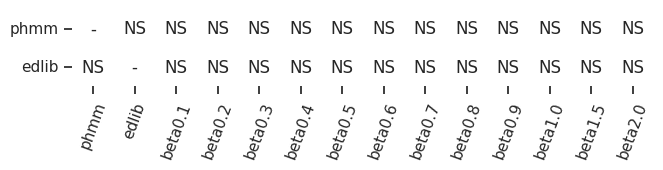

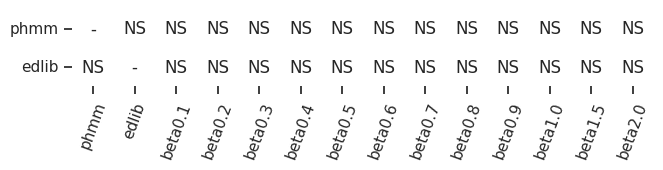

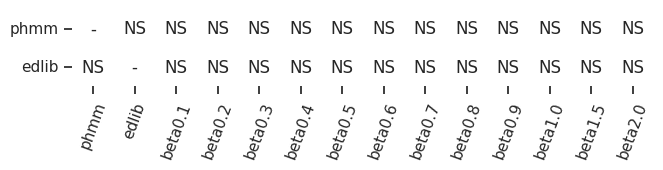

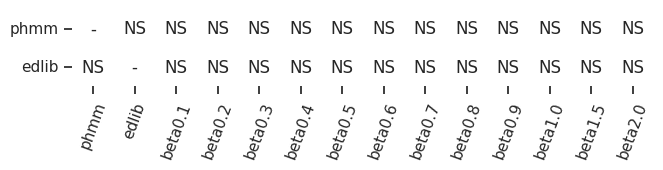

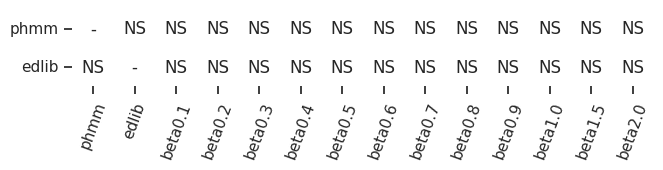

In [9]:
is_lsk114 = category_counts_all["name"].isin(["ont-10x-human", "ont-visium-mouse"])
not_visium_mouse_fast = ~(category_counts_all["name"].isin(["ont-visium-mouse"]) & category_counts_all["accuracy"].isin(["fast"]))
# not_phmm = ~category_counts_all["beta_or_backend"].isin(["phmm"])
# not_edlib = ~category_counts_all["beta_or_backend"].isin(["edlib"])

for category in categories:
    is_category = category_counts_all["structural_category"].isin([category])
    res_phmm = sp.posthoc_wilcoxon(
        category_counts_all[is_lsk114 & not_visium_mouse_fast & is_category],
        val_col="count",
        group_col="beta_or_backend",
        zero_method="zsplit",
        p_adjust="fdr_bh"
    )
    res_edlib = sp.posthoc_wilcoxon(
        category_counts_all[is_lsk114 & not_visium_mouse_fast & is_category],
        val_col="count",
        group_col="beta_or_backend",
        zero_method="zsplit",
        p_adjust="fdr_bh"
    )
    res = pd.concat([res_phmm.loc[["phmm"]], res_edlib.loc[["edlib"]]])
    res = res.loc[:, backends + betas]
    res.to_csv(f"output/wilcoxon_signed_rank_{category}_lsk114.csv")
    annot = sp.sign_table(res)
    fig, ax = plt.subplots(1,1,figsize=(7.5, 1))
    ax = sns.heatmap(
        data=res,
        annot=annot,
        fmt="s",
        cmap=ListedColormap("white"),
        cbar=False
    )
    # ax.xaxis.tick_top()
    ax.tick_params(axis="x", rotation=70)
    plt.savefig(f"output/wilcoxon_signed_rank_{category}_lsk114.svg", bbox_inches="tight")

In [10]:
is_lsk114 = category_counts_all["name"].isin(["ont-10x-human", "ont-visium-mouse"])
is_incomplete = category_counts_all["structural_category"] == "incomplete-splice_match"
retrieved_isoforms = category_counts_all[is_lsk114].groupby(["name", "beta_or_backend", "accuracy"]).sum()["count"].reset_index()
incomplete_isoforms = category_counts_all[is_lsk114 & is_incomplete].reset_index()

In [11]:
merged_df = pd.merge(
    retrieved_isoforms,
    incomplete_isoforms,
    on=["beta_or_backend", "name", "accuracy"],
    suffixes=("_all", "_incomplete")
)
merged_df

,name,beta_or_backend,accuracy,count_all,index,structural_category,count_incomplete,softwares,software_order
0,ont-10x-human,beta0.1,fast,1928,1,incomplete-splice_match,424,nanoprep,2
1,ont-10x-human,beta0.1,hac,2268,1,incomplete-splice_match,510,nanoprep,2
2,ont-10x-human,beta0.1,sup,2283,1,incomplete-splice_match,548,nanoprep,2
3,ont-10x-human,beta0.2,fast,2039,1,incomplete-splice_match,449,nanoprep,3
4,ont-10x-human,beta0.2,hac,2305,1,incomplete-splice_match,528,nanoprep,3
...,...,...,...,...,...,...,...,...,...
78,ont-visium-mouse,edlib,hac,3191,1,incomplete-splice_match,1834,pychopper,1
79,ont-visium-mouse,edlib,sup,3205,1,incomplete-splice_match,1868,pychopper,1
80,ont-visium-mouse,phmm,fast,2343,1,incomplete-splice_match,1237,pychopper,0
81,ont-visium-mouse,phmm,hac,3383,1,incomplete-splice_match,2024,pychopper,0


In [12]:
merged_df["percent_incomplete"] = merged_df["count_incomplete"] / merged_df["count_all"]

In [13]:
percent_incomplete = merged_df.groupby(["name", "accuracy", "beta_or_backend"]).describe()["percent_incomplete"].reset_index()
percent_incomplete.to_csv("output/percent_incomplete_isoform.csv", index=False)
percent_incomplete

,name,accuracy,beta_or_backend,count,mean,std,min,25%,50%,75%,max
0,ont-10x-human,fast,beta0.1,1.0,0.219917,NaN,0.219917,0.219917,0.219917,0.219917,0.219917
1,ont-10x-human,fast,beta0.2,1.0,0.220206,NaN,0.220206,0.220206,0.220206,0.220206,0.220206
2,ont-10x-human,fast,beta0.3,1.0,0.221895,NaN,0.221895,0.221895,0.221895,0.221895,0.221895
3,ont-10x-human,fast,beta0.4,1.0,0.227606,NaN,0.227606,0.227606,0.227606,0.227606,0.227606
4,ont-10x-human,fast,beta0.5,1.0,0.229749,NaN,0.229749,0.229749,0.229749,0.229749,0.229749
...,...,...,...,...,...,...,...,...,...,...,...
78,ont-visium-mouse,sup,beta1.0,1.0,0.589306,NaN,0.589306,0.589306,0.589306,0.589306,0.589306
79,ont-visium-mouse,sup,beta1.5,1.0,0.590309,NaN,0.590309,0.590309,0.590309,0.590309,0.590309
80,ont-visium-mouse,sup,beta2.0,1.0,0.589218,NaN,0.589218,0.589218,0.589218,0.589218,0.589218
81,ont-visium-mouse,sup,edlib,1.0,0.582839,NaN,0.582839,0.582839,0.582839,0.582839,0.582839
